In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

celeb_data = pd.read_csv('../list_attr_celeba.csv')

# clean the data
celeb_data.replace(1, 1.0, inplace=True)
celeb_data.replace(-1, 0.0, inplace=True)
celeb_data.drop(columns=[
    'image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Bags_Under_Eyes', 
    'Bushy_Eyebrows', 'Bangs', 'Blurry', 'Smiling', 'Mouth_Slightly_Open', 
    'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 
    'Wearing_Necktie'
], inplace=True)

column_names = celeb_data.drop("Attractive", axis=1).columns
X = celeb_data.drop("Attractive", axis=1).values
y = celeb_data["Attractive"].values

In [24]:
# chi-squared: x^2 = summation((observed(i) - expected(i)^2) / expected(i))

# feature selection
selector = SelectKBest(score_func=chi2, k=10)  # top 10 most relevant features
X_new = selector.fit_transform(X, y)

# names of distinct features
selected_features = column_names[selector.get_support()]
print("Features:", selected_features)

# training and testing split 70/30
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# convert the data to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # adds an extra dimension for binary classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# feedforward neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32) # first layer (32 neurons)
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(32, 16) # second layer (16 neurons)
        self.fc3 = nn.Linear(16, 1) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid func. for binary classification
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Features: Index(['Big_Nose', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Gray_Hair',
       'Heavy_Makeup', 'Male', 'Pointy_Nose', 'Wavy_Hair', 'Young'],
      dtype='object')


In [25]:
# initialize model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.BCELoss() # using binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # using adam optimizer

loss_values = []
# train model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# evaluate model
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs >= 0.5).float() # convert probabilities to binary

# need to convert to numpy to do sklearn metrics
y_pred_numpy = y_pred.squeeze().numpy()
y_test_numpy = y_test_tensor.squeeze().numpy()

Epoch [10/50], Loss: 0.6884
Epoch [20/50], Loss: 0.6763
Epoch [30/50], Loss: 0.6632
Epoch [40/50], Loss: 0.6466
Epoch [50/50], Loss: 0.6250


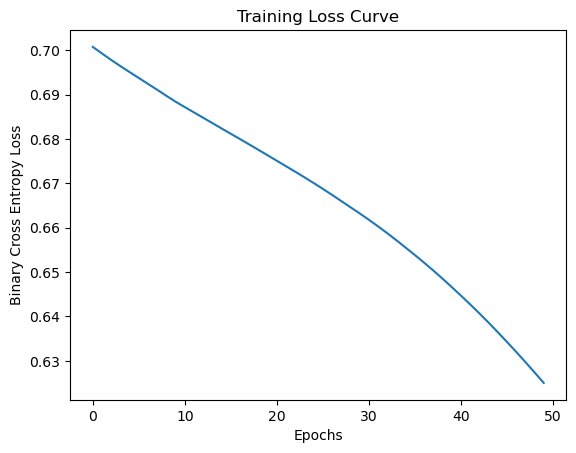

In [26]:
plt.plot(range(num_epochs), loss_values)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

In [28]:
# sorted importance
chi2_scores, p_values = chi2(X, y)
feature_importance = pd.DataFrame({
    'Feature': column_names,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
print(feature_importance)

              Feature    Chi2 Score        P-Value
11       Heavy_Makeup  28271.052943   0.000000e+00
13               Male  18385.501513   0.000000e+00
2            Big_Nose  11904.828502   0.000000e+00
6              Chubby  10713.529035   0.000000e+00
8          Eyeglasses   9393.708775   0.000000e+00
7         Double_Chin   8435.048004   0.000000e+00
10          Gray_Hair   7904.040885   0.000000e+00
19        Pointy_Nose   7629.404734   0.000000e+00
25              Young   6895.274619   0.000000e+00
24          Wavy_Hair   6371.880541   0.000000e+00
20  Receding_Hairline   5952.041000   0.000000e+00
17          Oval_Face   5454.974070   0.000000e+00
21        Rosy_Cheeks   5082.716829   0.000000e+00
0                Bald   4211.602687   0.000000e+00
4          Blond_Hair   4134.993162   0.000000e+00
9              Goatee   4081.602611   0.000000e+00
14           Mustache   3815.858803   0.000000e+00
5          Brown_Hair   2808.678556   0.000000e+00
12    High_Cheekbones   2454.34

In [30]:
# metrics
# accuracy
accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
print(f"Accuracy: {accuracy:.6f}")
# precision
precision = precision_score(y_test_numpy, y_pred_numpy)
print(f"Precision: {precision:.6f}")
# recall
recall = recall_score(y_test_numpy, y_pred_numpy)
print(f"Recall: {recall:.6f}")
# F1 score
f1 = f1_score(y_test_numpy, y_pred_numpy)
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.731853
Precision: 0.730279
Recall: 0.753237
F1 Score: 0.741581
